[Versión Interactiva](https://mybinder.org/v2/git/https%3A%2F%2Fgithub.com%2Fjuandadamo%2Fclases_fiuba/HEAD?filepath=6731%2Fconduccion-unidades-problema.ipynb)

In [1]:
%%capture
!pip install ht pint numpy matplotlib Coolprop xlrd xlwt

In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd
import ht,pint
import CoolProp as cp
import matplotlib.pyplot as plt
from IPython.display import  Latex
ureg = pint.UnitRegistry()#(fmt_locale='es_ES')

In [2]:
a = 1*ureg.km

In [4]:
a*2


2 <Unit('kilometer')>

## Problema 10
El rotor de una turbina de gas tiene 54 álabes de acero inoxidable AISI 302 de
dimensiones $L= 6$ cm, $A_ c = 4\cdot10^{-4}$ m$^2$ y $P= 0.1$ m. Cuando la corriente de gas está a
900 $^\circ$C, la temperatura de la base de los álabes es de 500 $^\circ$C. Calcule la carga
térmica sobre el sistema de enfriamiento interno del rotor si se admite que el
coeficiente de transferencia de calor por convección es de 440 W/m$^2$ K.

### Uso de la Librería Pint

La funcion `ureg` guarda las unidades

In [5]:
n_alabes = 54
#Unidad de Longitud
L = 6e-2*ureg.m
A_c = 4e-4*ureg.m**2
P = 0.1*ureg.m
#Unidad de Temperatura
T_gas = (900+273)*ureg.K
T_base = (500+273)*ureg.K
# Unidad de Potencia
h_conv = 440*ureg.watt/ureg.m**2/ureg.K

In [6]:
T_gas

1173 <Unit('kelvin')>

### Representación
Para mostrar los valores se usan expresiones de texto del tipo:

    f"{<variable>:<formato>}"
Los formatos los pueden copiar de los ejemplos o recuperar desde:[https://mkaz.blog/code/python-string-format-cookbook/](https://mkaz.blog/code/python-string-format-cookbook/)

Entonces, por ejemplo para mostrar la variable $L$:

In [7]:
print(f"L={L:.2f}")

L=0.06 meter


Para darle un poco mejor presentación, usamos `display(Latex () )`

In [8]:
L = 6*ureg.cm
display(Latex('$L=$'+f'{L:.1f}'))

<IPython.core.display.Latex object>

### Resultados de Teoría de Aletas
\begin{equation}\label{solq}
\dot Q =\frac{\theta_0\alpha P}{\beta} \tanh(\beta L)
\end{equation}

$$\beta^2=\frac{\alpha P}{\lambda S_t}$$

### Uso de la librería ht para obtener  la conductividad

In [9]:
acero_inox = ht.nearest_material('stainless steel')
k_acero_inox = ht.k_material(acero_inox)*ureg.watt/ureg.m/ureg.K
display(Latex('Conductividad del acero inoxidable $k_a=$'+f'{k_acero_inox:.1f}'))

<IPython.core.display.Latex object>

In [10]:
#Delta T del Problema de Aletas
theta_0 = T_gas-T_base
beta = (h_conv*P/(k_acero_inox*A_c) )**0.5

In [11]:
display(Latex(r'Parámetro de la aleta'))
display(Latex(r'$\beta$='+f' {beta:~.1f}'))
display(Latex(r'$\beta L$='+f' {(beta*L):~.2f}'))
# Para simplificar unidades
display(Latex(r'$\beta L$='+f' {(beta*L).to_base_units():~.2f}'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### Determinación del Flujo de calor $\dot Q$.

In [12]:
Q = theta_0*h_conv*P*np.tanh(beta*L)/beta
display(Latex(r'$\dot Q$='+f' {Q:~.1f}'))
Qtotal = Q*n_alabes
display(Latex(r'$\dot Q_{T}$='+f' {Qtotal.to(ureg.kW):~.1f}'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Para guardar en una variable la lista de todos los materiales disponibles en la librería `ht`.
Usamos librerías de manejo de datos json, pandas. No 

In [13]:
lista_materiales = ht.insulation.materials_dict

#Genero una lista de materiales
import json
lista_texto1 = json.dumps(lista_materiales)
#lista_texto1.split('"')
lista_texto1 = lista_texto1.replace(': ','').replace('{','').replace('}','').replace('"1, ','').replace('"2, ','').replace('"3, ','')
lista_texto1 = lista_texto1.split('"')[1:-1]

conductividades = np.zeros((len(lista_texto1)))
for i,listai in enumerate(lista_texto1):
    conductividades[i] = ht.k_material(listai)
#conductividades = conductividades *ureg.watt/ureg.m/ureg.K

In [14]:
data_materiales = pd.DataFrame({"Material":pd.Series(lista_texto1),"Conductividad [watt/m K]":pd.Series(conductividades)})

In [15]:
data_materiales

,Material,Conductividad [watt/m K]
0,Silica,1.20
1,Silica special,1.55
2,Fused silica,1.44
3,Fireclay,1.05
4,High-duty fireclay,1.20
...,...,...
385,"Wood, oriented strand board",0.13
386,"Wood, fibreboard, 250 kg/m^3",0.07
387,"Wood, fibreboard, 400 kg/m^3",0.10
388,"Wood, fibreboard, 600 kg/m^3",0.14


In [15]:
#si qusieramos grabar en un archivo
data_materiales.to_excel('Conductividad_materiales.xlsx')

## CoolProp
Usaremos la función:

`cp.CoolProp.PropsSI(<propiedad>,<temperatura referencia>,<presion referencia>,<fluido>)`

para ver una lista completa de las propiedades que podemos evaluar,
ver [http://www.coolprop.org/coolprop/HighLevelAPI.html](http://www.coolprop.org/coolprop/HighLevelAPI.html)

Veamos como se comporta la viscosidad y la conductividad del aire respecto a la temperatura a presión 1 atm:

In [17]:
Temperatura_1 = 25
mu = cp.CoolProp.PropsSI('V','T',273+Temperatura_1,'P',101.325e3,'Air')
rho = cp.CoolProp.PropsSI('D','T',273+Temperatura_1,'P',101.325e3,'Air')
nu = mu/rho * ureg.m**2/ureg.s
k_aire_1 = cp.CoolProp.PropsSI('conductivity','T',273+Temperatura_1,'P',101.325e3,'Air')*ureg.watt/ureg.m/ureg.K

In [18]:
display(Latex(r"$\nu=$"+f"{nu:.2e} a T={((Temperatura_1+273)*ureg.K).to('degC'):.0f}"))
display(Latex(r"$k=$"+f"{k_aire_1:.2e} a T={((Temperatura_1+273)*ureg.K).to('degC'):.0f}"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [19]:
# Definimos un vector de temperaturas

Temperaturas = np.linspace(0,600,25)  # inicio,final, numero de elementos
rhos, mus, nus, ks = np.tile(np.zeros_like(Temperaturas),[4,1])
for i, Temperatura in enumerate(Temperaturas):
    mus[i] = cp.CoolProp.PropsSI('V','T',273+Temperatura,'P',101.325e3,'Air')
    rhos[i] = cp.CoolProp.PropsSI('D','T',273+Temperatura,'P',101.325e3,'Air')
    nus[i] = mus[i]/rhos[i] 
    ks[i] = cp.CoolProp.PropsSI('conductivity','T',273+Temperatura,'P',101.325e3,'Air')
    
idpol = np.polyfit(Temperaturas+273,nus,2)
p1 = np.poly1d(idpol)
idpol2 = np.polyfit((Temperaturas+273),ks**2,1)
pk = np.poly1d(idpol2)

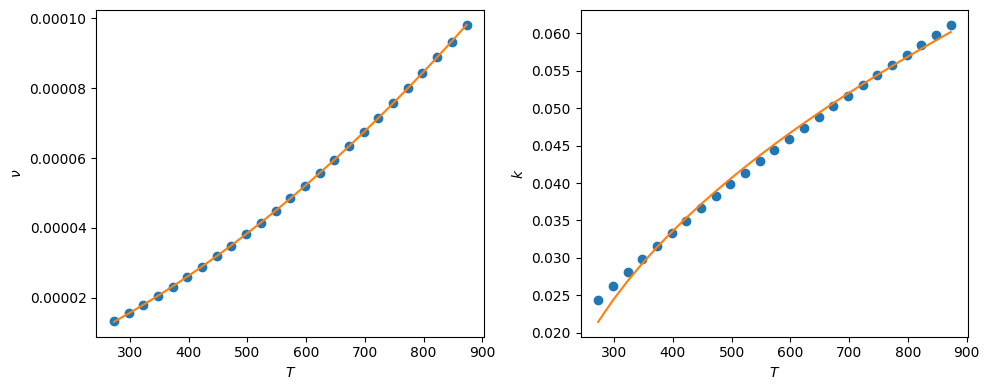

In [20]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax0,ax1 = ax
ax0.plot(Temperaturas+273,nus,'o',label='data')
ax0.plot(Temperaturas+273,p1(Temperaturas+273),label='Ajuste')
ax0.set_ylabel(r'$\nu$')
ax0.set_xlabel('$T$');

ax1.plot( (Temperaturas+273),ks,'o',label='data')
ax1.plot((Temperaturas+273),pk((Temperaturas+273))**.5,label='Ajuste')
ax1.set_ylabel(r'$k$')
ax1.set_xlabel('$T$');
fig.tight_layout()

In [21]:
pk(273)**.5, ks[0]

(0.021460813966475274, 0.024348994714412812)

In [315]:
ht.

1.5530604260593228e-05

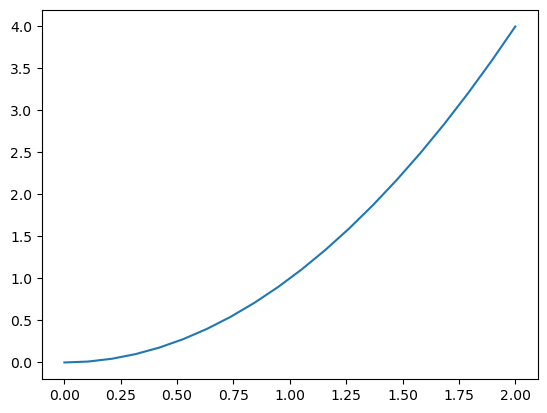

In [18]:
x = np.linspace(0,2,20)
y = x**2

fig,ax = plt.subplots()
ax.plot(x,y)
inty = np.trapz(y,x)

In [19]:
inty

2.670360110803324